In [1]:
%reset -f
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns

In [3]:
### Mnist data
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.examples.tutorials.mnist import mnist

mnist_data = input_data.read_data_sets("MNIST_data/", one_hot=True)
num_samples = mnist_data.train.num_examples
m_dim = mnist.IMAGE_PIXELS
p_dim = mnist.NUM_CLASSES
batch_size = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def get_rand_batch(data):
    inds = np.random.choice(num_samples, batch_size)
    for i in range(len(data)):
        data[i] = data[i][inds]
    return inds, data

In [5]:
x_data = mnist_data.train.images
y_data = mnist_data.train.labels

In [6]:
### Model
tf.reset_default_graph()

layers = 5
l_dim = [m_dim] + (layers-1)*[50] + [p_dim]
stddev = 0.05
b_init = 0.1

# Placeholders
x_in = tf.placeholder(tf.float32, shape=[batch_size, m_dim], name='x_in')
y = tf.placeholder(tf.float32, shape=[batch_size, p_dim], name='y')

# hyperparameters
keep_prob = tf.placeholder(tf.float32)

# Variables
# what is best way to create arbitrary layer network?
# dicts or lists?
b = []
W = []
h = []
x = []

for i in range(layers):
    with tf.name_scope('layer'+str(i)) as scope:
        b.append(tf.Variable(tf.constant(b_init, shape=[1, l_dim[i+1]]), name='b'+str(i)))
        W.append(tf.Variable(tf.truncated_normal([l_dim[i], l_dim[i+1]], stddev=stddev), name='W'+str(i)))
        if i == 0:
            h.append(tf.add(tf.matmul(x_in, W[i]), b[i], name='h'+str(i)))
        else:
            h.append(tf.add(tf.matmul(x[i-1], W[i]), b[i], name='h'+str(i)))
        x.append(tf.nn.dropout(tf.nn.relu(h[i]), keep_prob, name='x'+str(i)))

y_hat = tf.nn.softmax(x[-1])

# Possible loss functions
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
#loss = tf.reduce_mean(0.5*(x[-1] - y)**2, name="loss")

## Evaluation ops
# categorical output
correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_op = tf.train.AdamOptimizer(1e-3)
#train_op = tf.train.GradientDescentOptimizer(0.1)
train = train_op.minimize(loss)

In [7]:
tf.scalar_summary('loss', loss)
tf.scalar_summary('learning rate', train_op._lr_t)
tf.scalar_summary('learning rate2', train_op._lr)
tf.scalar_summary('accuracy', accuracy)

merged_summary_op = tf.merge_all_summaries()

In [8]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', sess.graph)

for i in range(10000):
    inds_batch, [x_batch, y_batch] = get_rand_batch([x_data, y_data])
    _, loss_val, summary_str, accuracy_val = sess.run([train, loss, merged_summary_op, accuracy],
                                                      feed_dict={x_in: x_batch, y: y_batch, keep_prob: 0.95})
    summary_writer.add_summary(summary_str, i)
    
    if i % 100 == 0:
        print "iter:", "%04d" % (i), \
              "loss:", "{:.4f}".format(loss_val), \
              "accuracy:", "{:.2f}".format(accuracy_val)

print "finished"

iter: 0000 loss: 2.3064 accuracy: 0.11
iter: 0100 loss: 0.8941 accuracy: 0.72
iter: 0200 loss: 0.4749 accuracy: 0.87
iter: 0300 loss: 0.5679 accuracy: 0.84
iter: 0400 loss: 0.5538 accuracy: 0.83
iter: 0500 loss: 0.4855 accuracy: 0.85
iter: 0600 loss: 0.3419 accuracy: 0.89
iter: 0700 loss: 0.4018 accuracy: 0.87
iter: 0800 loss: 0.2735 accuracy: 0.92
iter: 0900 loss: 0.3400 accuracy: 0.89
iter: 1000 loss: 0.5550 accuracy: 0.82
iter: 1100 loss: 0.3862 accuracy: 0.90
iter: 1200 loss: 0.3346 accuracy: 0.91
iter: 1300 loss: 0.4275 accuracy: 0.84
iter: 1400 loss: 0.3577 accuracy: 0.89
iter: 1500 loss: 0.5757 accuracy: 0.84
iter: 1600 loss: 0.2898 accuracy: 0.93
iter: 1700 loss: 0.2017 accuracy: 0.94
iter: 1800 loss: 0.3919 accuracy: 0.88
iter: 1900 loss: 0.2928 accuracy: 0.89
iter: 2000 loss: 0.3479 accuracy: 0.88
iter: 2100 loss: 0.2744 accuracy: 0.93
iter: 2200 loss: 0.2221 accuracy: 0.93
iter: 2300 loss: 0.2697 accuracy: 0.89
iter: 2400 loss: 0.2195 accuracy: 0.92
iter: 2500 loss: 0.3708 a

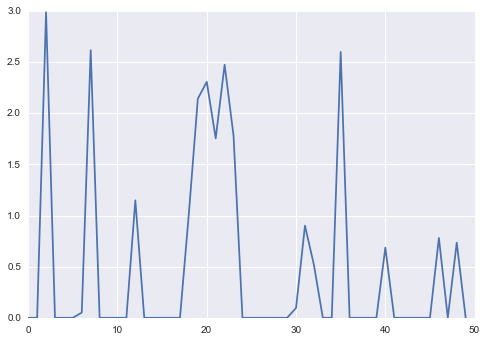

In [9]:
plt.plot(sess.run(x[-4][0,:], feed_dict={x_in: x_batch, y: y_batch, keep_prob: 1}))

plt.show()